In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit

plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [3]:
sim_time = 16 * 2*np.pi
steps = 160
tlist = np.linspace(0, sim_time, steps+1)
tlist_long = np.linspace(0, sim_time, steps*10+1)

In [4]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, \
    ion4_top, ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, \
    ion6_bottom, ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None,
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

def get_pops_from_fileno(no, steps):
    _, pop = readFile('Dephasing_%s'%str(no).zfill(3))
    return np.array(pop[:steps])

def get_pops_list_from_fileno(no_list, steps):
    pop_list = []
    for no in no_list:
        pop = get_pops_from_fileno(no, steps)
        pop_list += [pop]
    return np.array(pop_list).reshape((len(no_list), -1))

In [5]:
def get_pops(params, option='c'):
    
    Nmax = params['Nmax']
    H = params['eps']/2 * tensor(sigmaz(), qeye(Nmax))
    H += params['Delta']/2 * tensor(sigmax(), qeye(Nmax))
    H += params['kappa']/2 * tensor(sigmaz(), (destroy(Nmax) + create(Nmax)))  
    H += params['nu'] * tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    init_state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, params['nbar']))
    tlist = params['tlist']
    e_op = tensor(ket2dm(basis(2,0)), qeye(Nmax))
    e_op2 = tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    if option == 'c':
        c_ops = [np.sqrt(params['Gamma'] * (params['nbar'] + 1)) * tensor(qeye(2), destroy(Nmax))]
        if params['nbar'] > 0:
            c_ops += [np.sqrt(params['Gamma'] * params['nbar']) * tensor(qeye(2), create(Nmax))]
    elif option == 'd':
        c_ops = [np.sqrt(params['Gamma']) * tensor(qeye(2), create(Nmax) * destroy(Nmax))]
        
    result = mesolve(H, init_state, tlist, e_ops=[e_op, e_op2], c_ops=c_ops)
    pops = result.expect[0]
    phonons = result.expect[1]
    
    return pops, phonons

def sim_fn(t, Gamma):
    params = {'nu': 1., 'eps': 0., 'Delta': 1., 'kappa': .1, 'Gamma': Gamma, 'nbar': 0.,
              'tlist': t, 'Nmax': 10}
    pops, _ = get_pops(params)
    return pops

def fit_fn(t, Gamma): 
    params = {'nu': 1., 'eps': 0., 'Delta': 1., 'kappa': .1, 'Gamma': Gamma, 'nbar': 0.036,
              'tlist': t, 'Nmax': 10}
    pops, _ = get_pops(params)
    return pops

In [14]:
Gamma_list = [0., 0.05, 0.15, 0.25, 0.4]
fileno_lists = [[0]]
fileno_lists += [np.arange(1, 21).tolist()]
fileno_lists += [np.arange(21, 41).tolist()]
fileno_lists += [np.arange(41, 61).tolist()]
fileno_lists += [np.arange(61, 81).tolist()]

simdata_list = []
expdata_list = []
errorbar_list = []
fitdata_list = []

fitted_Gamma_list = []
fitted_Gamma_std_list = []

##################################################

Gamma = Gamma_list[0]
fileno = fileno_lists[0][0]

simdata_list += [sim_fn(tlist_long, Gamma)]
expdata = get_pops_from_fileno(fileno, steps)
errorbar = np.maximum(np.sqrt(expdata * (1-expdata) / 100), 1e-3)
expdata_list += [expdata]
errorbar_list += [errorbar]

popt, pcov = curve_fit(fit_fn, tlist[:-1], expdata, p0=[Gamma], sigma=errorbar, absolute_sigma=True,\
                       bounds =([0.], [np.inf]))
fitted_Gamma_list += [popt[0]]
fitted_Gamma_std_list += [np.sqrt(np.diag(pcov))[0]]
fitdata_list += [fit_fn(tlist_long, *popt)]

print('target Gamma: ', Gamma)
print('fitted Gamma, nu: ', popt)
print('fitted std: ', np.sqrt(np.diag(pcov)))
print('')

for i in range(1, len(Gamma_list)):
    Gamma = Gamma_list[i]
    fileno_list = fileno_lists[i]
    
    simdata_list += [sim_fn(tlist_long, Gamma)]
    expdata_all = get_pops_list_from_fileno(fileno_list, steps)
    expdata = np.mean(expdata_all, axis=0)
    expdata_list += [expdata]
    
    variance = np.std(expdata_all, axis=0)**2 / len(fileno_list)
    shotnoise = np.maximum(np.sqrt(expdata_all * (1-expdata_all) / 100), 1e-3)
    variance = variance + np.mean(shotnoise**2, axis=0)
    errorbar = np.sqrt(variance)
    errorbar_list += [errorbar]
    
    popt, pcov = curve_fit(fit_fn, tlist[:-1], expdata, p0=[Gamma], sigma=errorbar, absolute_sigma=True)
    fitted_Gamma_list += [popt[0]]
    fitted_Gamma_std_list += [np.sqrt(np.diag(pcov))[0]]
    fitdata_list += [fit_fn(tlist_long, *popt)]
    
    print('target Gamma: ', Gamma)
    print('fitted Gamma, nu: ', popt)
    print('fitted std: ', np.sqrt(np.diag(pcov)))
    print('')

target Gamma:  0.0
fitted Gamma, nu:  [2.e-10]
fitted std:  [0.00069577]

target Gamma:  0.05
fitted Gamma, nu:  [0.04155244]
fitted std:  [0.00277165]

target Gamma:  0.15
fitted Gamma, nu:  [0.1465398]
fitted std:  [0.00706698]

target Gamma:  0.25
fitted Gamma, nu:  [0.22624822]
fitted std:  [0.00985828]

target Gamma:  0.4
fitted Gamma, nu:  [0.34828471]
fitted std:  [0.01413747]



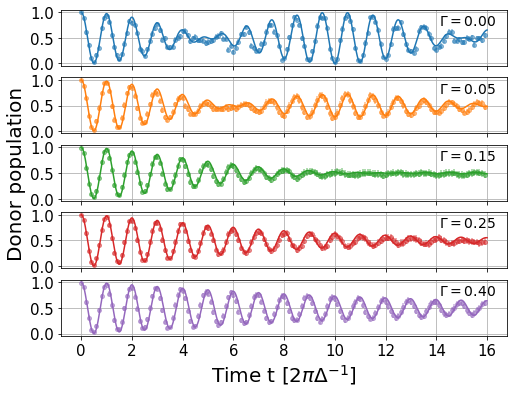

In [15]:
color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

fig, axs = plt.subplots(5, 1, figsize=(8,6), gridspec_kw={'hspace': 0.2})
for i in range(len(expdata_list)):
    axs[i].plot(tlist_long/2/np.pi, simdata_list[i], '-', color=color_list[i], label=r'$\Gamma=%.2f$'%Gamma_list[i])
    axs[i].errorbar(tlist[:-1]/2/np.pi, expdata_list[i], yerr=errorbar_list[i], fmt='o', alpha=0.5,\
                    markersize=4, color=color_list[i], ecolor=color_list[i], mfc=color_list[i])
#     axs[i].plot(tlist_long/2/np.pi, fitdata_list[i], '--', color='k', label='fit', alpha=0.8)
    axs[i].grid()  
    axs[i].set_yticks([0.0, 0.5, 1.0])
#     axs[i].legend(loc = 'upper right')
#     axs[i].set_title(r'$\Gamma=%.2f$'%Gamma_list[i]);
    axs[i].text(14.1, 0.75, r'$\Gamma =  %.2f$'%(Gamma_list[i]), fontsize=14)
    axs[i].label_outer()
    
# plt.tight_layout()
axs[4].set_xlabel(r'Time t [$2\pi\Delta^{-1}]$')
axs[2].set_ylabel('Donor population');
plt.savefig('Figure2_21.png', dpi=300, bbox_inches='tight')

In [16]:
Gamma_list = np.array(Gamma_list)

Gamma_20trials_mean_list = np.array([0., 0.05135549, 0.1518433, 0.24975014, 0.39363661])
Gamma_20trials_std_list = np.array([0., 0.00958757, 0.02807076, 0.04971193, 0.08023603])
Gamma_200trials_mean_list = np.array([0., 0.05086448, 0.14946952, 0.24461752, 0.38397018])
Gamma_200trials_std_list = np.array([0., 0.00354842, 0.00683788, 0.01106221, 0.02207796])

fig, ax = plt.subplots(1, figsize=(5,3))
ax.plot(Gamma_list, Gamma_list, '-', color='k')
ax.errorbar(Gamma_list, fitted_Gamma_list, yerr=fitted_Gamma_std_list,\
            ls = '', marker='o',mec='firebrick', ecolor='firebrick',mfc='pink', label='Exp')

ax.fill_between(Gamma_list, 
                Gamma_20trials_mean_list - Gamma_20trials_std_list, 
                Gamma_20trials_mean_list + Gamma_20trials_std_list, color='tab:brown', alpha=0.4, label='20 trials')

ax.fill_between(Gamma_list, 
                Gamma_200trials_mean_list - Gamma_200trials_std_list, 
                Gamma_200trials_mean_list + Gamma_200trials_std_list, color='tab:blue', alpha=0.4, label='200 trials')

ax.set_xlabel('Target ' + r'$\Gamma$ [$\Delta$]')
ax.set_ylabel('Fitted ' + r'$\Gamma$ [$\Delta$]')

ax.legend();
plt.savefig('Figure2_22.png', dpi=300, bbox_inches='tight')

In [17]:
def get_Lorentzian(wlist, nu, Gamma, kappa):   
    return kappa**2 * Gamma/2 * (1 / ((wlist - nu)**2 + (Gamma/2)**2) - 1 / ((wlist + nu)**2 + (Gamma/2)**2)) 

w_list = np.linspace(0.8, 1.2, 1001)

fig, ax = plt.subplots(1, figsize=(5, 3))
for i in range(1, len(Gamma_list)):
    ax.plot(w_list, get_Lorentzian(w_list, 1, Gamma_list[i], 0.1), '-', color=color_list[i], label=r'$\Gamma=%.2f$'%Gamma_list[i])    
    ax.plot(w_list, get_Lorentzian(w_list, 1, fitted_Gamma_list[i], 0.1), '-.', color=color_list[i])
    
    ax.fill_between(w_list, 
                    get_Lorentzian(w_list, 1, Gamma_20trials_mean_list[i] - Gamma_20trials_std_list[i], 0.1), 
                    get_Lorentzian(w_list, 1, Gamma_20trials_mean_list[i] + Gamma_20trials_std_list[i], 0.1), 
                    color=color_list[i], alpha=0.2)
ax.set_xlabel(r'Frequency $\omega$ [$\Delta$]')
ax.set_ylabel(r'$J(\omega)$ [$\Delta$]')
ax.legend()
plt.savefig('Figure2_23.png', dpi=300, bbox_inches='tight')